In [1]:
import argparse

In [2]:
import os
import numpy as np
import torch
import warnings
import argparse
import sys

In [3]:
from main import *

In [4]:
def parse_args():
    parser = argparse.ArgumentParser(description='.')
    parser.add_argument("--arch", type=str, help="Neural network architecture")
    parser.add_argument(
        "--class-cond",
        action="store_true",
        default=False,
        help="train class-conditioned diffusion model",
    )
    parser.add_argument(
        "--diffusion-steps",
        type=int,
        default=1000,
        help="Number of timesteps in diffusion process",
    )
    parser.add_argument(
        "--sampling-steps",
        type=int,
        default=250,
        help="Number of timesteps in diffusion process",
    )
    parser.add_argument(
        "--ddim",
        action="store_true",
        default=False,
        help="Sampling using DDIM update step",
    )
    # dataset
    parser.add_argument("--dataset", type=str)
    parser.add_argument("--data-dir", type=str, default="./dataset/")
    # optimizer
    parser.add_argument(
        "--batch-size", type=int, default=128, help="batch-size per gpu"
    )
    parser.add_argument("--lr", type=float, default=0.0001)
    parser.add_argument("--epochs", type=int, default=500)
    parser.add_argument("--ema_w", type=float, default=0.9995)
    # sampling/finetuning
    parser.add_argument("--pretrained-ckpt", type=str, help="Pretrained model ckpt")
    parser.add_argument("--delete-keys", nargs="+", help="Pretrained model ckpt")
    parser.add_argument(
        "--sampling-only",
        action="store_true",
        default=False,
        help="No training, just sample images (will save them in --save-dir)",
    )
    parser.add_argument(
        "--num-sampled-images",
        type=int,
        default=50000,
        help="Number of images required to sample from the model",
    )

    # misc
    parser.add_argument("--save-dir", type=str, default="./trained_models/")
    parser.add_argument("--local_rank", default=0, type=int)
#     parser.add_argument("--seed", default=112233, type=int)

    args = parser.parse_args(args=[])
    warnings.filterwarnings("ignore")

    return args

In [5]:
args = parse_args()

In [6]:
args.arch = "UNet"
args.dataset = "celeba" #Enter data name
args.epoch = 30  
args.save_dir = './models/'
args.data_dir = '../data/'
args.ddim = True 
args.epochs = 100
args.class_cond = True
args.batch_size = 256

In [7]:
os.environ["RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "29536"

In [8]:
def cleanup():
    dist.destroy_process_group()
    
# setup(int(os.environ["RANK"]), int(os.environ["WORLD_SIZE"]))

In [9]:
metadata = get_metadata(args.dataset)

In [10]:
metadata.num_classes =  2

In [11]:
torch.backends.cudnn.benchmark = True
args.device = "cuda:{}".format(args.local_rank)
torch.cuda.set_device(args.device)
# torch.manual_seed(args.seed + args.local_rank)
# np.random.seed(args.seed + args.local_rank)
if args.local_rank == 0:
    print(args)

# Creat model and diffusion process
model = unets.__dict__[args.arch](
    image_size=metadata.image_size,
    in_channels=metadata.num_channels,
    out_channels=metadata.num_channels,
    num_classes=metadata.num_classes if args.class_cond else None,
).to(args.device)
if args.local_rank == 0:
    print(
        "We are assuming that model input/ouput pixel range is [-1, 1]. Please adhere to it."
    )
diffusion = GuassianDiffusion(args.diffusion_steps, args.device)
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)


Namespace(arch='UNet', batch_size=256, class_cond=True, data_dir='../data/', dataset='celeba', ddim=True, delete_keys=None, device='cuda:0', diffusion_steps=1000, ema_w=0.9995, epoch=30, epochs=100, local_rank=0, lr=0.0001, num_sampled_images=50000, pretrained_ckpt=None, sampling_only=False, sampling_steps=250, save_dir='./models/')
We are assuming that model input/ouput pixel range is [-1, 1]. Please adhere to it.


In [16]:
model_name = "ENTER_MODEL_NAME.pt"

In [17]:
def load_model(model_name, model_location = './models/'):
    model = unets.__dict__[args.arch](
        image_size=metadata.image_size,
        in_channels=metadata.num_channels,
        out_channels=metadata.num_channels,
        num_classes=metadata.num_classes if args.class_cond else None,
        ).to(device)
    pretrained_ckpt = model_location + model_name
    print(f"Loading pretrained model from {pretrained_ckpt}")
    d = fix_legacy_dict(torch.load(pretrained_ckpt, map_location=args.device))
    dm = model.state_dict()
    if args.delete_keys:
        for k in args.delete_keys:
            print(
                f"Deleting key {k} becuase its shape in ckpt ({d[k].shape}) doesn't match "
                + f"with shape in model ({dm[k].shape})"
            )
            del d[k]
    model.load_state_dict(d, strict=False)
    print(
        f"Mismatched keys in ckpt and model: ",
        set(d.keys()) ^ set(dm.keys()),
    )
    print(f"Loaded pretrained model from {pretrained_ckpt}")
    return model

In [18]:
device = args.device

In [ ]:
model = load_model(model_name)

In [20]:
diffusion = GuassianDiffusion(args.diffusion_steps, device)

In [21]:
ngpus = torch.cuda.device_count()

In [22]:
torch.distributed.init_process_group(backend="nccl", init_method="env://")

In [23]:
scalars = diffusion.get_all_scalars(diffusion.alpha_bar_scheduler, 1000, device)

In [24]:
def sample_from_reverse_process(
    model, xT = None, timesteps=1000, model_kwargs={}, ddim=True
):
    if xT is None:
        xT = (
            torch.randn(args.batch_size, metadata.num_channels, metadata.image_size, metadata.image_size)
            .float()
            .to(args.device)
        )
    scalars = diffusion.get_all_scalars(diffusion.alpha_bar_scheduler, timesteps, device)
    betas = scalars['beta']
    alpha_bar = scalars["alpha_bar"]
    model.eval()
    final = xT
    return_list = torch.tensor([])
    finals = [final, final]
    scores = [0, 0]
    
    for t in np.arange(timesteps)[::-1]:
        with torch.no_grad():
            for y_cond in range(2):
                y = torch.ones((len(xT),), dtype=torch.int64).to(
                    args.device
                ) * y_cond
                model_kwargs = {"y": y}
                current_t = torch.tensor([t] * len(xT), device=args.device)
                pred_epsilon = model(finals[y_cond], current_t, **model_kwargs)
                scores[y_cond] = pred_epsilon#/(1-alpha_bar[t])
                pred_x0 = diffusion.get_x0_from_xt_eps(
                    finals[y_cond], pred_epsilon, current_t, scalars
                )
                pred_mean = diffusion.get_pred_mean_from_x0_xt(
                    finals[y_cond], pred_x0, current_t, scalars
                )
                if t == 0:
                    finals[y_cond] = pred_mean
                else:
                    if ddim:
                        finals[y_cond] = (
                            unsqueeze3x(scalars["alpha_bar"][current_t - 1]).sqrt()
                            * pred_x0
                            + (
                                1 - unsqueeze3x(scalars["alpha_bar"][current_t - 1])
                            ).sqrt()
                            * pred_epsilon
                        )
                    else:
                        finals[y_cond] = pred_mean + unsqueeze3x(
                            scalars.beta_tilde[current_t].sqrt()
                        ) * torch.randn_like(finals[y_cond])
                finals[y_cond] = finals[y_cond].detach()
            return_list = torch.cat([return_list, (betas[t] * (scores[0]-scores[1])).cpu().unsqueeze(dim = 0)])#
    return  return_list

In [25]:
return_list = sample_from_reverse_process(model)

In [26]:
diff_taus_mean = []
for tau in range(0, 1000, 10):
    to_tau = torch.sum(return_list[:1000-tau], dim = 0)
    from_tau = torch.sum(return_list[1000-tau:], dim = 0)
    diff_taus_mean.append(torch.mean(torch.norm(from_tau - to_tau, dim = 0)))
#     print(1000-tau, torch.mean(torch.norm(from_tau - to_tau, dim = 0)))

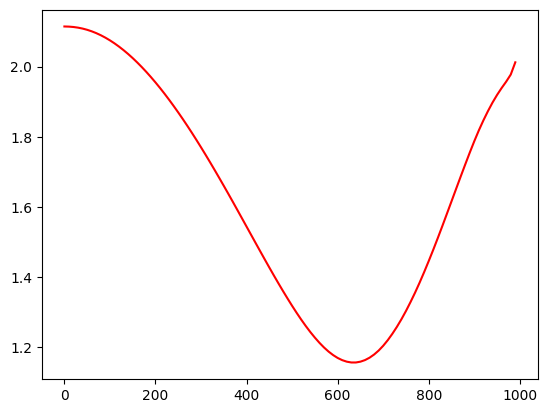

In [27]:
import matplotlib.pyplot as plt
plt.plot(range(0, 1000, 10), diff_taus_mean, c = 'r')
plt.show()